In [2]:
import os
import re
import json
import numpy as np
import pandas as pd

# Set base_dir to the experiment_results folder for the mixed-data experiment.
base_dir = '/share/amine.mcharrak/mixed_data_final/custom_mixed_confounding_softplus/experiment_results'

# List of JSON files (e.g. results_n500.json, results_n1000.json, etc.)
json_files = [f for f in os.listdir(base_dir) if f.startswith("results_n") and f.endswith(".json")]

# Regular expression to extract sample size from file name.
n_pattern = re.compile(r'results_n(\d+)\.json')

# Define the metrics to include in the table.
metrics = [
    "SHD_absolute", "SHD_normalized",
    "SID_absolute", "SID_normalized",
    "AID_absolute", "AID_normalized",
    "F1_Score", "TEE", "AUROC", "AUPRC",
    "True_Total_Effect", "Estimated_Total_Effect"
]

# Collect all records as a list of dicts.
records = []

# Loop over each JSON file.
for fname in json_files:
    m = n_pattern.search(fname)
    if not m:
        continue
    sample_size = int(m.group(1))
    json_path = os.path.join(base_dir, fname)
    try:
        with open(json_path, 'r') as f:
            data = json.load(f)
    except Exception as ex:
        print(f"Error reading {json_path}: {ex}")
        continue
    # Each file contains an array of seed results.
    for entry in data:
        seed = entry.get("seed")
        # Loop over each metric.
        for metric in metrics:
            metric_dict = entry.get(metric)
            if metric_dict is None:
                continue
            # Each metric is a dictionary mapping method names to values.
            for method, value in metric_dict.items():
                if value is None:
                    continue  # Skip missing values.
                try:
                    value = float(value)
                except Exception:
                    continue
                records.append({
                    "sample_size": sample_size,
                    "seed": seed,
                    "method": method,
                    "metric": metric,
                    "value": value
                })

# Create a DataFrame with all results.
df = pd.DataFrame(records)
if df.empty:
    raise ValueError("No valid data found.")

# For each metric, group by sample_size and method, compute mean and std.
tables = {}
for metric in metrics:
    df_metric = df[df['metric'] == metric]
    if df_metric.empty:
        continue
    agg_df = df_metric.groupby(["sample_size", "method"])["value"].agg(['mean', 'std']).reset_index()
    # Create a table with sample_size as rows and methods as columns.
    sample_sizes = sorted(df_metric['sample_size'].unique())
    methods = sorted(df_metric['method'].unique())
    table = pd.DataFrame(index=sample_sizes, columns=methods)
    for s in sample_sizes:
        for mth in methods:
            sub = agg_df[(agg_df['sample_size'] == s) & (agg_df['method'] == mth)]
            if sub.empty:
                table.loc[s, mth] = ""
            else:
                mean_val = sub['mean'].values[0]
                std_val = sub['std'].values[0]
                table.loc[s, mth] = f"{mean_val:.2f} ± {std_val:.2f}"
    tables[metric] = table

# Write a LaTeX table for each metric.
output_dir = os.path.expanduser('~/pcax/examples/mixed_data_plots_and_tables')
os.makedirs(output_dir, exist_ok=True)

for metric, table in tables.items():
    table.index.name = "$n$"
    # Replace underscores in column names with spaces.
    table.columns = [col.replace('_', ' ') for col in table.columns]
    # Create a “safe” version for the caption and label.
    safe_metric = metric.replace('_', ' ')    # For the caption.
    safe_label = metric.replace('_', '-')       # For the label.
    caption = f"{safe_metric} for the mixed confounding dataset as sample size ($n$) increases."
    label = f"tab:{safe_label}"
    latex_table = table.style.to_latex(caption=caption, label=label)
    out_file = os.path.join(output_dir, f"{metric}_table.tex")
    with open(out_file, "w") as f:
        f.write(latex_table)


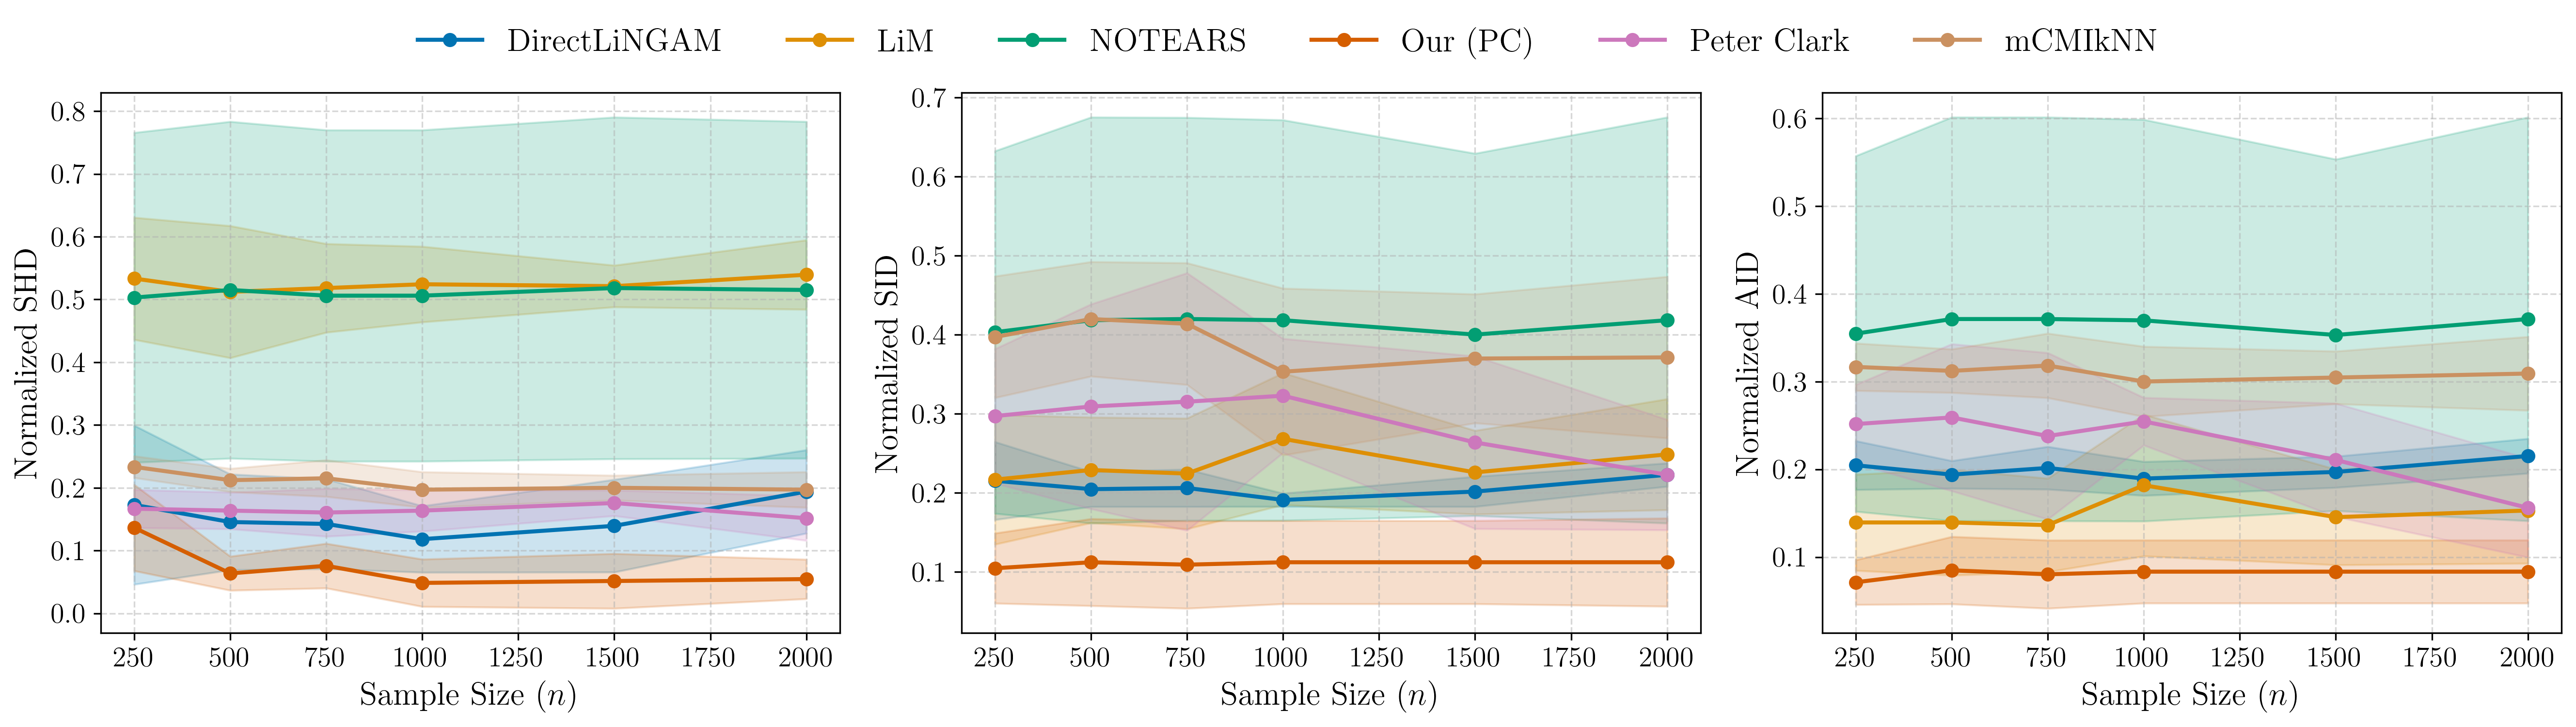

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define output directory and file path.
output_dir = os.path.expanduser("~/pcax/examples/mixed_data_plots_and_tables")
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "SHD_SID_AID_metrics_plot.pdf")

# Use a colorblind-friendly palette from Seaborn.
methods = sorted(df["method"].unique())
color_palette = sns.color_palette("colorblind", n_colors=len(methods))

# Increase font sizes for clarity.
plt.rcParams.update({
    "text.usetex": True, # Set to False if you don't have LaTeX installed
    "font.family": "serif",
    "font.size": 16,         # Base font size
    "axes.titlesize": 18,    # Axis title font size
    "axes.labelsize": 16,    # Axis label font size
    "legend.fontsize": 16,   # Legend font size
    "xtick.labelsize": 14,
    "ytick.labelsize": 14,
    "figure.dpi": 300,
})

# Create a 1x3 figure layout.
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# The three metrics to plot.
plot_metrics = ["SHD_normalized", "SID_normalized", "AID_normalized"]

def metric_to_ylabel(metric):
    # E.g. "SHD_normalized" -> "Normalized SHD"
    base = metric.split('_')[0].upper()  # "SHD", "SID", or "AID"
    return f"Normalized {base}"

for idx, (metric, ax) in enumerate(zip(plot_metrics, axes)):
    df_metric = df[df["metric"] == metric]
    
    # Plot each method with mean ± std shading.
    for method, color in zip(methods, color_palette):
        df_method = df_metric[df_metric["method"] == method]
        if not df_method.empty:
            grouped = df_method.groupby("sample_size")["value"]
            means = grouped.mean()
            stds = grouped.std()
            
            ax.plot(means.index, means.values, label=method,
                    marker='o', linestyle='-', linewidth=2,
                    markersize=6, color=color)
            ax.fill_between(means.index, means - stds, means + stds,
                            alpha=0.2, color=color)
    
    ax.set_xlabel("Sample Size ($n$)")
    ax.set_ylabel(metric_to_ylabel(metric))
    ax.grid(True, linestyle="--", alpha=0.5)

# Let tight_layout handle spacing between subplots.
fig.tight_layout()

# Add extra space at the top for the legend.
fig.subplots_adjust(top=0.9)

# Create a legend at the top center.
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels,
           loc="upper center",
           bbox_to_anchor=(0.5, 1.03),  # 1.03 puts it slightly above the top edge
           ncol=len(methods),
           frameon=False,
           fontsize=16)

# Save the figure as PDF (high resolution).
fig.savefig(output_path, format="pdf", bbox_inches="tight")

plt.show()


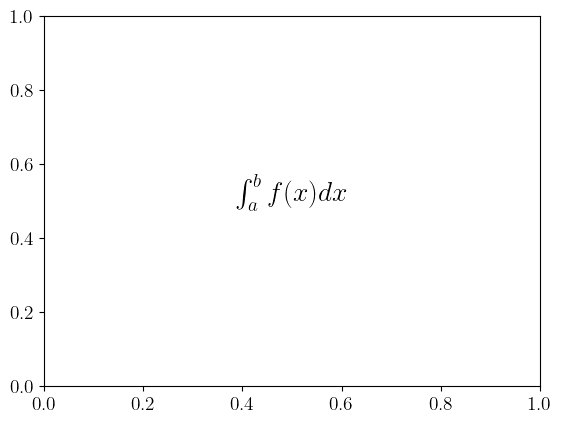

In [1]:
import os
import matplotlib.pyplot as plt

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 14,
})

fig, ax = plt.subplots()
ax.text(0.5, 0.5, r"$\int_a^b f(x) dx$", fontsize=20, ha='center')

plt.show()
